# Analysis of 103k entries from the WOS

State of OA dataset

**Results are not 100% correct (some FB engagement numbers are missing) as some errors occured in the data collection**

Will be eventually updated if we run the fixed script again for this data.

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json

from pprint import pprint

sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2})

plt.rcParams["figure.figsize"] = (9,5)

In [3]:
def JSONParser(data):
    j = json.loads(data)
    if j: 
        return j
    else:
        return None

converters={"url": str,
       "doi": str,
       "og_id": str,
       "oh_obj":JSONParser,
       "fb_comments":str,
       "fb_comment_plugins":str,
       "fb_reactions":str,
       "fb_shares":str,
       "am_posts":str,
       "am_response":JSONParser,
        "timestamp":str}

full_df = pd.read_csv("state_oa.csv", converters=converters)

wos = pd.read_csv("../data/wos_100k.csv", encoding = 'utf8')
full_df = full_df.merge(wos, on="doi")

In [4]:
full_df.am_posts = pd.to_numeric(full_df.am_posts, errors='coerce')

full_df.fb_shares = pd.to_numeric(full_df.fb_shares, errors='coerce')
full_df.fb_reactions = pd.to_numeric(full_df.fb_reactions, errors='coerce')
full_df.fb_comment_plugins = pd.to_numeric(full_df.fb_comment_plugins, errors='coerce')
full_df.fb_comments = pd.to_numeric(full_df.fb_comments, errors='coerce')

full_df['am_score'] = pd.to_numeric([x['score'] if x else None for x in full_df.am_response], errors='coerce')
full_df['fb_total'] = pd.to_numeric(full_df.fb_shares + full_df.fb_reactions + full_df.fb_comment_plugins + full_df.fb_comments, errors='coerce')

# Table of Contents

## Bad rows (DOI resolve errors, URL-OG mapping errors)

ATM 25k rows are removed because of:

+ Remove bad urls (if resolved URL appears more than once in the results -> removed)
+ Remove entries with DOI resolve errors
+ Remove all entries with identical OG IDs
+ Exclude papers before 2008 and after 2015


## Some stats

**Frequencies**

Few stats for number of found articles across platform, years, and OA status

+ [Frequencies across years](#Frequencies-across-years)
+ [Frequencies across OA colors](#Frequencies--across-OA-color)
+ [Frequencies across years, OA-colors](#Frequencies-across-years,-OA-colors)
+ [Relative frequencies across years, OA colors](#Relative-frequencies-across-years,-OA-colors)


**Shares**

Stats for the average number of shares across platform , years, and OA status.
Median numbers not included as they are quite boring (lots of 0 shares for FB, lots of 1 shares for Altmetric)

+ [Average shares across years](#Average-shares-across-years)
+ [Average shares across OA colors](#Average-shares-across-OA-colors)
+ [Average shares across years and OA colors](#Average-shares-across-years-and-OA-colors)

**Correlations**

+ [Correlation](#Correlation)

# Bad rows

In [5]:
print("The Bad Boyz\n")

# DOI resolving errors

resolve_errors = full_df[[x in ["timeout", "RequestException", "tooManyRedirects"] for x in full_df.url]]
pprint(resolve_errors.url.value_counts())
print("")

# Bad OG object mapping DOI -> URL -> OG

a = full_df.og_id.value_counts().keys()[full_df.og_id.value_counts() > 1][1:]
tdf = full_df[[x in a for x in full_df.og_id]][["doi", "url", "og_id", "fb_shares", "am_posts"]]
pprint(tdf.describe().loc['count'])

# Export the "bad" DOIs as CSV files
resolve_errors[['doi', 'url']].to_csv("recrawl_doi.csv", index=False)
tdf[['doi', 'url']].to_csv("bad_urls.csv", index=False)

The Bad Boyz

timeout             5100
RequestException    4984
tooManyRedirects    1687
Name: url, dtype: int64

fb_shares    13469.0
am_posts       822.0
Name: count, dtype: float64


Clean df and remove bad results :

In [34]:
bad_resolves = [x[:46] == "http://onlinelibrary.wiley.com/resolve/doi?DOI" for x in full_df.url]

bad_urls = list(full_df.url.value_counts().keys()[full_df.url.value_counts() > 1])
bad_url_papers = [x in bad_urls for x in full_df.url]

bad_og_id = list(full_df.og_id.value_counts().keys()[full_df.og_id.value_counts() > 1])[1:]
bad_og_papers = [x in bad_og_id for x in full_df.og_id]

min_year = 2008
max_year = 2015
too_early = [x < min_year for x in full_df.year]
too_late = [x > max_year for x in full_df.year]

bad_papers = list(np.any([bad_resolves, bad_url_papers, too_early, too_late, bad_og_papers], 0))

df = full_df[[not _ for _ in bad_papers]]

print("Bad URLs: {}".format(sum(bad_url_papers)))
print("Bad OG IDs: {}".format(sum(bad_og_papers)))
print("Incompletely resolved Wiley DOIs: {}".format(sum(bad_resolves)))
print("Paper <2008: {}".format(sum(too_early)))
print("Paper >2015: {}".format(sum(too_late)))

print("Total removed papers: {}".format(sum(bad_papers)))

Bad URLs: 12026
Bad OG IDs: 13469
Incompletely resolved Wiley DOIs: 10958
Paper <2008: 29
Paper >2015: 16
Total removed papers: 25290


http://www.nejm.org/doi/10.1056/NEJMsa1406751


## Preprocessing

Replace NaNs with 0.0 if either altmetric response or OG object was found, but on shares

In [17]:
def update_vals(row):
    if row['am_response'] and np.isnan(row['am_posts']):
        row['am_posts'] = 0.0
    if row['og_id'] and np.isnan(row['fb_shares']):
        row['fb_shares'] = 0.0
    return row

df.apply(update_vals, axis=1);

In [18]:
# Transformed dataframe for year/oa_color_long/platform plotting
pdf = df[['doi','year', 'oa_color_long', 'am_posts', 'fb_shares']].melt(id_vars = ['doi', 'year', 'oa_color_long'], var_name="platform", value_name="shares")
df[['doi','year', 'oa_color_long', 'am_posts', 'fb_shares','am_response', ]]

,doi,year,oa_color_long,am_posts,fb_shares,am_response
4,10.1371/journal.pone.0007695,2009.0,gold,NaN,NaN,"{'score': 1, 'images': {'small': 'https://badg..."
49,10.1371/journal.pone.0119813,2015.0,gold,NaN,NaN,"{'score': 0.25, 'images': {'small': 'https://b..."
93,10.1371/journal.pone.0118273,2015.0,gold,NaN,NaN,"{'score': 1.25, 'images': {'small': 'https://b..."
209,10.1371/journal.pone.0062113,2013.0,gold,NaN,NaN,{'citation': {'doi': '10.1371/journal.pone.006...
218,10.1371/journal.pgen.1000437,2009.0,gold,NaN,NaN,"{'score': 19.056, 'images': {'small': 'https:/..."
310,10.1371/journal.pone.0061633,2013.0,gold,NaN,NaN,"{'score': 0, 'images': {'small': 'https://badg..."
481,10.1371/journal.pone.0118823,2015.0,gold,NaN,NaN,{'demographics': {'geo': {'mendeley': {'CO': 1...
515,10.1371/journal.pone.0116728,2015.0,gold,NaN,NaN,{'demographics': {'users': {'mendeley': {'by_s...
534,10.1371/journal.pone.0052739,2013.0,gold,NaN,NaN,None
553,10.1371/journal.pone.0129598,2015.0,gold,NaN,NaN,{'demographics': {'geo': {'mendeley': {'IT': 1...


In [32]:
url = df.sort_values('am_posts', ascending=False).iloc[4].url

In [8]:
from ATB.Altmetric import Altmetric
from ATB.Facebook import Facebook
from ATB.DBConnection import DBConnection

import argparse, configparser
Config = configparser.ConfigParser()
Config.read('config.cnf')

# Load config
FACEBOOK_APP_ID = Config.get('facebook', 'app_id')
FACEBOOK_APP_SECRET = Config.get('facebook', 'app_secret')
ALTMETRIC_KEY = Config.get('altmetric', 'key')

In [9]:
fb = Facebook(app_id=FACEBOOK_APP_ID, app_secret=FACEBOOK_APP_SECRET)

Generated access token: 287299458433880|6Y_ml710QWnU7HBYLWjaneoWVKU


In [12]:
import urllib.parse

In [44]:
url = df[df.fb_shares.isnull()].sort_values('am_posts', ascending=False).head(100).sample(1).iloc[0].url
print(url)
#url = 'http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0092816'
fb_response = fb.get_object(id=urllib.parse.quote_plus(url), fields="engagement, og_object")
fb_response

http://www.nejm.org/doi/10.1056/NEJMoa1310519


{'engagement': {'comment_count': 0,
  'comment_plugin_count': 0,
  'reaction_count': 0,
  'share_count': 0},
 'id': 'http://www.nejm.org/doi/10.1056/NEJMoa1310519'}

In [14]:
fb_response

{'engagement': {'comment_count': 41,
  'comment_plugin_count': 0,
  'reaction_count': 225,
  'share_count': 97},
 'id': 'http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0092816',
 'og_object': {'description': 'Background Debate has surrounded the legalization of marijuana for medical purposes for decades. Some have argued medical marijuana legalization (MML) poses a threat to public health and safety, perhaps also affecting crime rates. In recent years, some U.S. states have legalized marijuana for medical purposes, reigniting political and public interest in the impact of marijuana legalization on a range of outcomes.  Methods Relying on U.S. state panel data, we analyzed the association between state MML and state crime rates for all Part I offenses collected by the FBI.  Findings Results did not indicate a crime exacerbating effect of MML on any of the Part I offenses. Alternatively, state MML may be correlated with a reduction in homicide and assault rates, net of 

## Frequencies across years

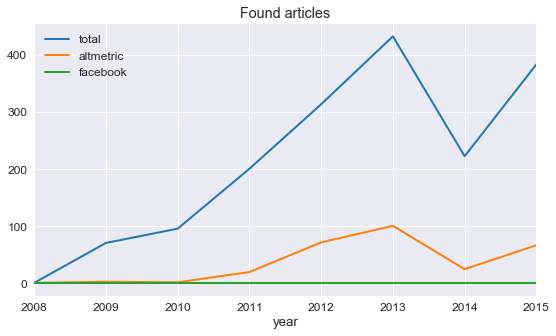

In [20]:
df.groupby(['year'])[['doi','am_posts', 'fb_shares']].count().plot();
plt.xlim([min_year, max_year]);
plt.gca().legend(labels=["total", "altmetric", "facebook"]);
plt.title("Found articles");

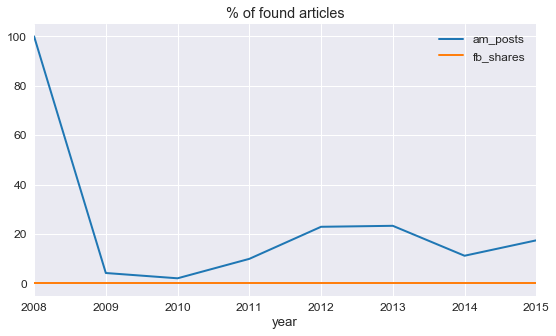

In [21]:
a = df.groupby(['year']).count()
(100*a[['am_posts', 'fb_shares']].divide(a.doi,0)).plot();
plt.title("% of found articles");

## Frequencies  across OA color

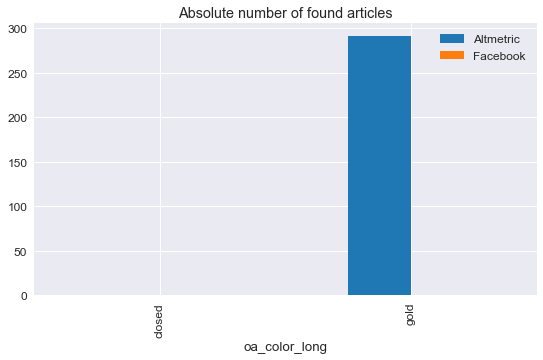

In [22]:
df.groupby(['oa_color_long'])[['am_posts', 'fb_shares']].count().plot(kind="bar");
plt.title("Absolute number of found articles")
plt.gca().legend(labels=["Altmetric", "Facebook"]);

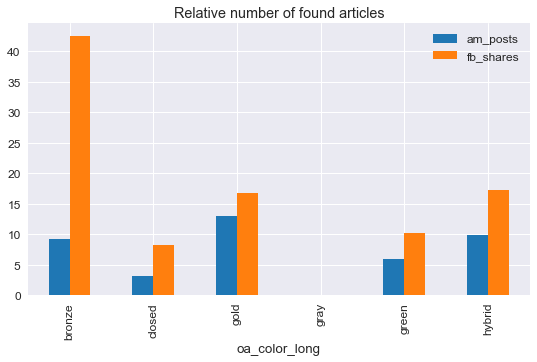

In [12]:
a = df.groupby(['oa_color_long']).count()
(100*a[['am_posts', 'fb_shares']].divide(a.doi,0)).plot(kind="bar");
plt.title("Relative number of found articles");

## Frequencies across years, OA colors

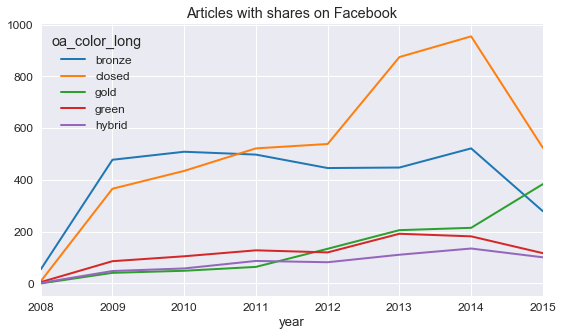

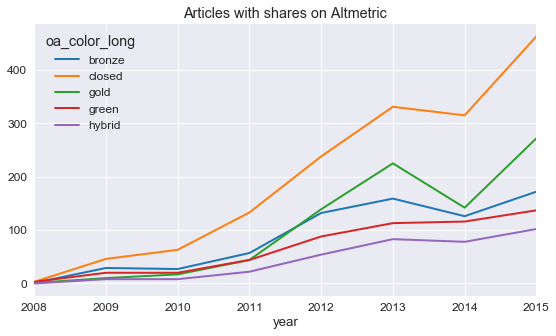

In [13]:
df.groupby(['year','oa_color_long'])['fb_shares'].count().unstack().plot()
plt.title("Articles with shares on Facebook");
df.groupby(['year','oa_color_long'])['am_posts'].count().unstack().plot()
plt.title("Articles with shares on Altmetric");

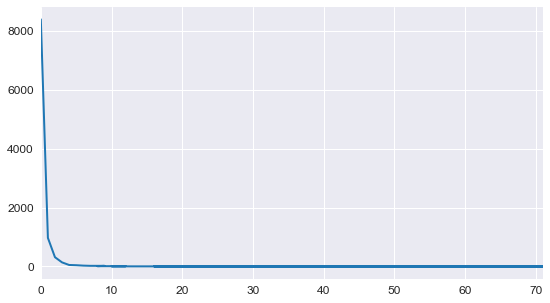

In [23]:
df.fb_shares.value_counts().plot()

## Relative frequencies across years, OA colors

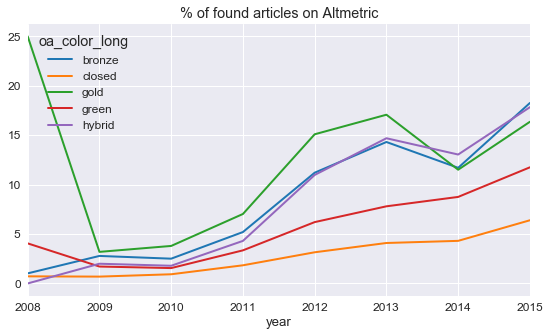

In [14]:
_ = pdf[pdf.platform=="am_posts"].groupby(["year", "oa_color_long"]).count()
a = _['shares']/_['doi']
(100*a).unstack().plot()
plt.title("% of found articles on Altmetric");

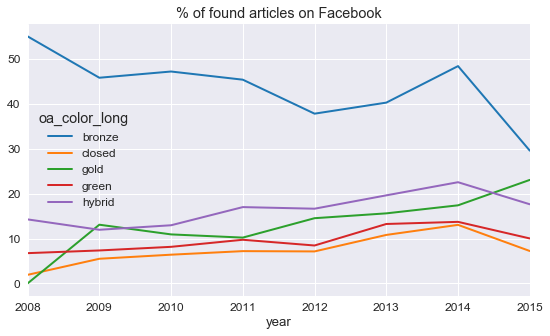

In [15]:
_ = pdf[pdf.platform=="fb_shares"].groupby(["year", "oa_color_long"]).count()
a = _['shares']/_['doi']
(100*a).unstack().plot();
plt.title("% of found articles on Facebook");

## Average shares across years

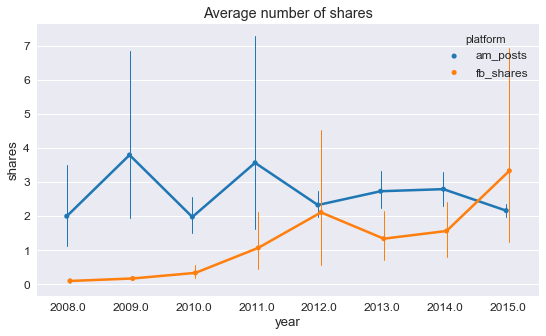

In [16]:
sns.pointplot(x="year", y="shares", hue="platform", data=pdf,
              estimator=np.mean,
              dodge=True, errwidth=1, markers=".", scale=0.7);
plt.title("Average number of shares");

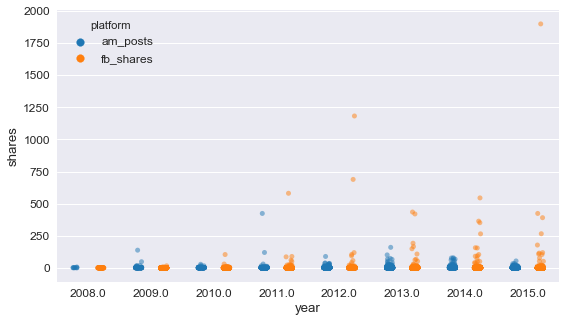

In [17]:
sns.stripplot(x="year", y="shares", hue="platform", data=pdf, jitter=True, dodge=True, alpha=.5);

## Average shares across OA colors

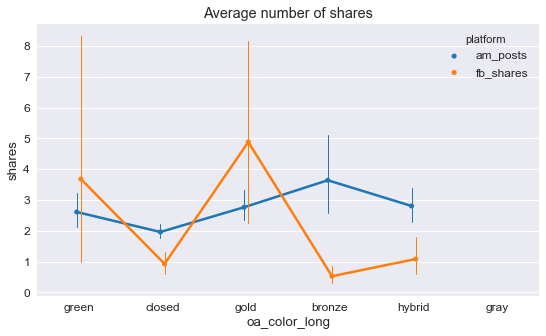

In [18]:
sns.pointplot(x="oa_color_long", y="shares", hue="platform", data=pdf,
              estimator=np.mean,
              dodge=True, errwidth=1, markers=".", scale=0.7);
plt.title("Average number of shares");

## Average shares across years and OA colors

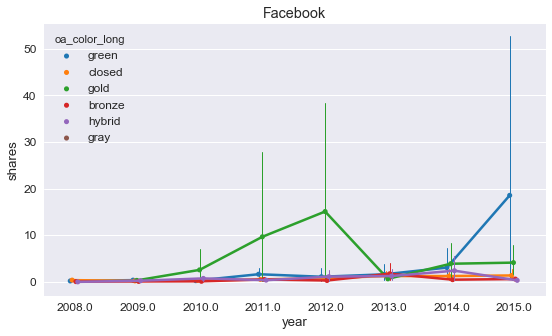

In [19]:
sns.pointplot(x="year", y="shares", hue="oa_color_long", data=pdf[pdf.platform == "fb_shares"],
              estimator=np.mean,
              dodge=True, errwidth=1, markers=".", scale=0.7);
plt.title("Facebook");

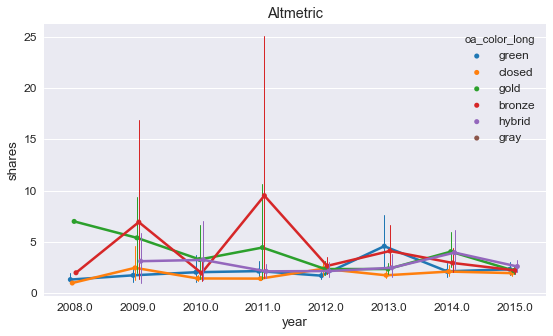

In [20]:
sns.pointplot(x="year", y="shares", hue="oa_color_long", data=pdf[pdf.platform == "am_posts"],
              estimator=np.mean,
              dodge=True, errwidth=1, markers=".", scale=0.7);
plt.title("Altmetric");

## Correlation

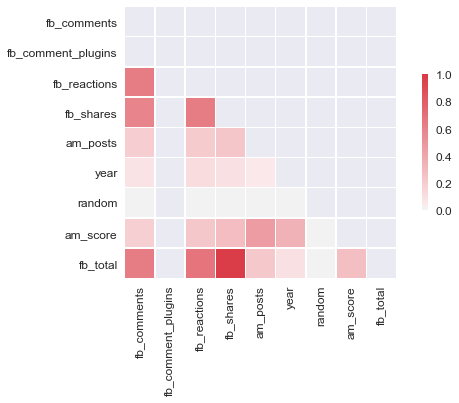

In [8]:
corr = df.corr(method = "spearman")

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, mask=mask, vmin=0, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})